In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dtaidistance import dtw, dtw_c, dtw_ndim
from numpy.random import choice, shuffle
from torch import nn
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

In [108]:
%load_ext autoreload
%autoreload 1

from preprocessing import *
from models import Encoder, Decoder, Sequence2Sequence

%aimport preprocessing
%aimport models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example of multidimensional time-series

In [109]:
# !mkdir -p data
# !wget https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/UCRArchive_2018.zip ../data
# !unzip data/UCRArchive_2018.zip -d ../data

In [110]:
# data_path = "../data/UCRArchive_2018/Earthquakes/Earthquakes_TRAIN.tsv"

In [111]:
# data = pd.read_csv(data_path, header=None, delimiter="\t").values

# # to remove Nan (only first columns)
# data = data[:, ~np.isnan(data).any(0)]

# X = data[:, 1:]
# y = data[:, 0].astype(np.short)

# Accelerometer dataset 

- 1: Working at Computer
- 2: Standing Up, Walking and Going up\down stairs
- 3: Standing
- 4: Walking
- 5: Going Up\Down Stairs
- 6: Walking and Talking with Someone
- 7: Talking while Standing

In [112]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip -O ../data/Accelerometer.zip
# ! unzip ../data/Accelerometer.zip -d ./data

In [113]:
from torch.utils.data import DataLoader, TensorDataset, random_split

def train_test_valid_split(dataset: TensorDataset, test_size: float, valid_size: float):
    test_size = int(len(dataset) * test_size)
    valid_size = int(len(dataset) * valid_size)
    train_size = len(dataset) - test_size - valid_size
    assert train_size > 0, "Invalid size of train set"
    assert len(dataset) == test_size + valid_size + train_size, "Invalid sum of sizes"
    
    return random_split(dataset, [train_size, test_size, valid_size])

In [114]:
CHANNELS = ['0', '1', '2']
LABELS = [1, 4, 5, 6]
LENGTH = 100
start_ident = 200

sample_size = 200
device = torch.device("cuda")

w = 4
k = 10

In [115]:
np.random.seed(0)


dataset = {label: [] for label in LABELS}

for i in range(1, 11):
    data_path = "../data/Activity Recognition from Single Chest-Mounted Accelerometer/{0}.csv".format(i)
    data = pd.read_csv(data_path,
                   names=['0', '1', '2', "labels"],
                   index_col=0,
                   dtype=np.float)
    
    for label in LABELS:
        X = get_class_timeseries(label, data, start_ident)
        X = np.linalg.norm(X, axis=1)[np.newaxis].T
        dataset[label].extend(slice_timeseries(X, LENGTH))
    
max_count = min([len(x) for x in dataset.values()])
for label, ts in dataset.items():
    dataset[label] = [ts[idx] for idx in choice(range(len(ts)), max_count, replace=False)]
    
X = np.array([zscore(x) for _, ts in dataset.items() for x in ts])
y = [np.repeat(label, len(ts)) for label, ts in dataset.items()]
X = np.hstack(X).T
y = np.hstack(y).T

# X = [split_to_sequence(x, k, w) for x in X]

In [116]:
ds = SplittedDataset(X, y, k, w, device=device)
train_ds, test_ds, valid_ds = train_test_valid_split(ds, 0.4, 0.1)

train_set = DataLoader(train_ds, batch_size=1024, shuffle=True)
test_set = DataLoader(test_ds, batch_size=1024, shuffle=True)
valid_set = DataLoader(valid_ds, batch_size=24, shuffle=True)

In [117]:
from models import Encoder, Decoder, Sequence2Sequence

input_dim = 2*k
hidden_dim = 5
n_layers = 1

enc = Encoder(input_dim, hidden_dim, 1, n_layers)
dec = Decoder(hidden_dim, input_dim, 1, n_layers)

In [118]:
model = Sequence2Sequence(enc, dec)
model.to(device)

Sequence2Sequence(
  (encoder): Encoder(
    (lstm): LSTM(20, 5)
  )
  (decoder): Decoder(
    (lstm): LSTM(5, 20)
  )
)

In [119]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())

In [120]:
N_STEP = 1000

def train(model, train_ds, optim, valid_ds):
    model.train()
    for step in range(N_STEP):
        it = iter(train_ds)
        for batch, _, _ in it:
            batch = batch.permute(1, 0, 2)
            optim.zero_grad()
            out = model(batch)
            loss = loss_fn(batch, out)

            if step % 100 == 0:
                print("Loss:", loss)

            loss.backward()
            optim.step()

            if step % 500 == 0:
                valid(model, valid_ds)
                model.train()

def valid(model, valid_ds):
    model.eval()
    loss = 0.
    it = iter(valid_ds)
    for batch, _, _ in it:
        batch = batch.permute(1, 0, 2)
        out = model(batch)
        loss += loss_fn(batch, out)
    
    print("Valid loss:", loss)

In [134]:
N_STEP = 3000

train(model, train_set, optim, test_set)

Loss: tensor(0.3084, device='cuda:0', grad_fn=<MeanBackward0>)
Valid loss: tensor(0.3207, device='cuda:0', grad_fn=<AddBackward0>)
Loss: tensor(0.3074, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3065, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3056, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3048, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3041, device='cuda:0', grad_fn=<MeanBackward0>)
Valid loss: tensor(0.3166, device='cuda:0', grad_fn=<AddBackward0>)
Loss: tensor(0.3034, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3028, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3022, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3017, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3011, device='cuda:0', grad_fn=<MeanBackward0>)
Valid loss: tensor(0.3138, device='cuda:0', grad_fn=<AddBackward0>)
Loss: tensor(0.3006, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3002, device='cuda:0', gr

In [135]:
torch.save(model.state_dict(), "../data/pretrained.pcl")

In [122]:
valid_it = iter(valid_set)
batch, timeseries, labels = next(valid_it)

In [123]:
id0 = 10
id1 = 5

x_out = model(batch).cpu().detach().numpy()

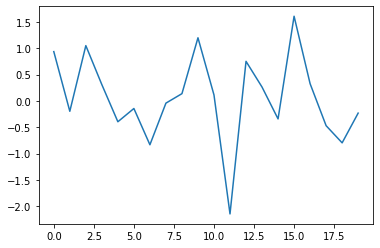

In [124]:
plt.plot(batch[id0, id1].cpu())

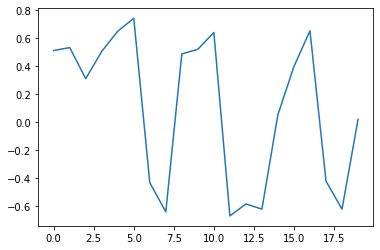

In [125]:
plt.plot(x_out[id0, id1])

In [136]:
timeseries.numpy().shape

(24, 100)

In [137]:
dtw_ndim.distance(x1[0], x1[1])

3.2670165991451214

In [138]:
dtw_ndim.distance(x1[0], x1[1])

3.2670165991451214

In [143]:
matrix_ts = dtw.distance_matrix(timeseries)

In [141]:
matrix_hidden = dtw_ndim.distance_matrix(x_out)

In [142]:
matrix_hidden.shape

(24, 24)

In [144]:
matrix_ts.shape

(24, 24)